## Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Multiprocessing
import multiprocessing
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
num_cores = multiprocessing.cpu_count()
client = Client()
# Multiprocessing

import glob
import gc
from sklearn.model_selection import train_test_split

import random
import utilities as util
import augmentations as aug

## Model Creation

We create a UNET Model that takes a binned image that has a size of 128x160 (originally 512x640)

In [3]:
input_shape = (128, 160, 1)
output_channels = 1
sigma_noise = 0
channels_list =  [256 , 128 , 64 , 32]

kernel_initializer='glorot_uniform'
#kernel_initializer='he_normal'

def unet():
    unet_input = tf.keras.layers.Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='relu', kernel_initializer=kernel_initializer, padding='same', name=f'Encoder_conv_{i}')(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        #print(f'encoder layer number {i} number of channel {n_channels}')
        list_features.append((n_channels, x))
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        #print(f'decoder layer number {i} number of channel {n_channels}')
        #print(f'concat decoder layer number {i} number of channel {same_reso_features}')
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, same_reso_features])
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', padding='same', kernel_initializer=kernel_initializer, name=f'Decoder_conv_{i}')(x)
        #x = tf.keras.layers.Dropout(0.1)(x)

    if sigma_noise > 0:
            x = tf.keras.layers.GaussianNoise(sigma_noise)(x)

    unet_output = tf.keras.layers.Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(unet_input, unet_output, name='unet')

    return model

In [4]:
gc.collect()

30

We use a learning rate of 0.001 that decays using a Keras call back\
We use a BinaryCrossEntropy loss (log loss) which will classify each pixel as True or False (True meaning there is a cloud, False means there is no cloud)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Preprocessing

### Data Augmentation

### DATA loading

Load fits file that contains the binned image and its mask

In [6]:
DR = 2**14
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data

    del image

    cloud  = cloud / DR
    return cloud , mask

In [7]:
images_list = glob.glob('/gdrive/MyDrive/BIN_MASKED_SUBSET/*.fits')
images_list = images_list

Shuffle the images

In [10]:
import random
images_list = random.choices(images_list, k=len(images_list))

In [11]:
with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=1)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   30.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   31.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done 1444 out of 1444 | elapsed:   33.5s finished


In [12]:
gc.collect()

742

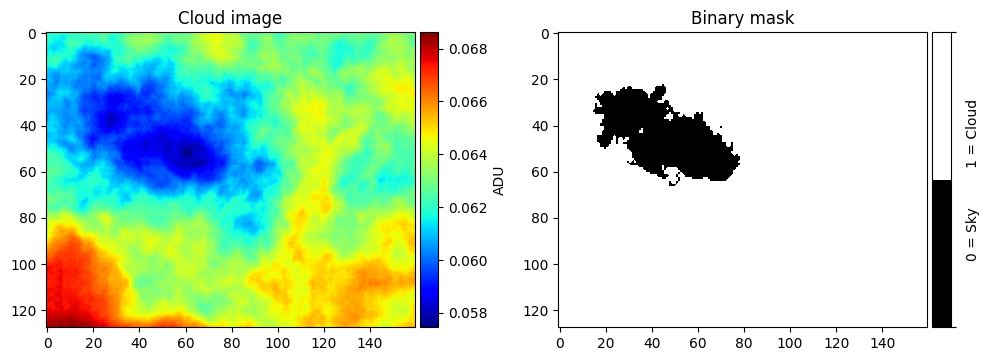

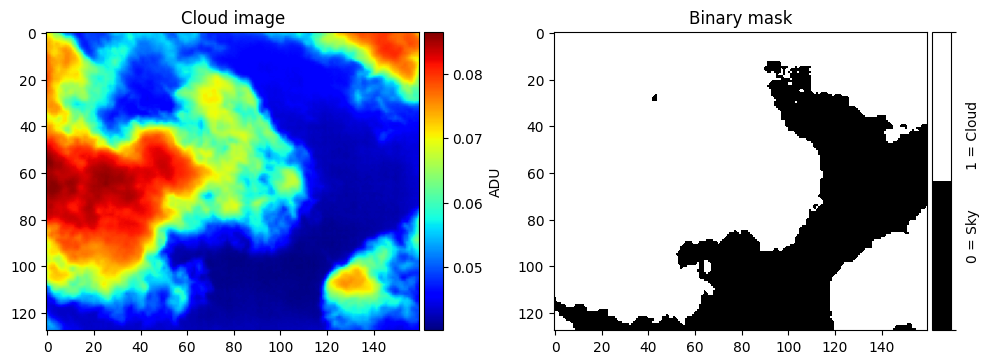

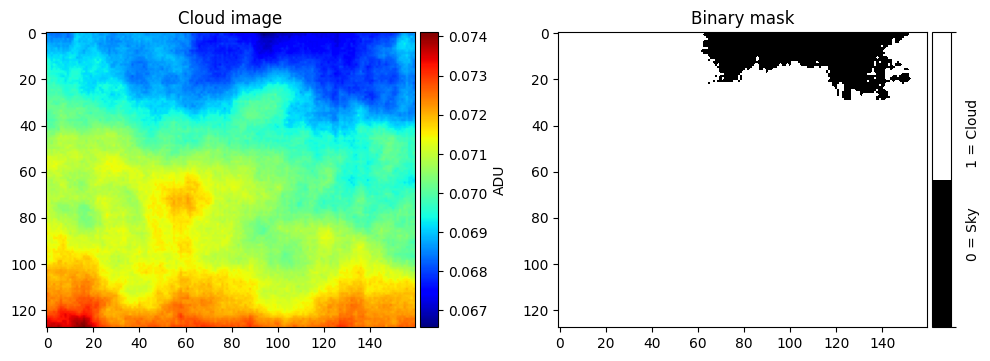

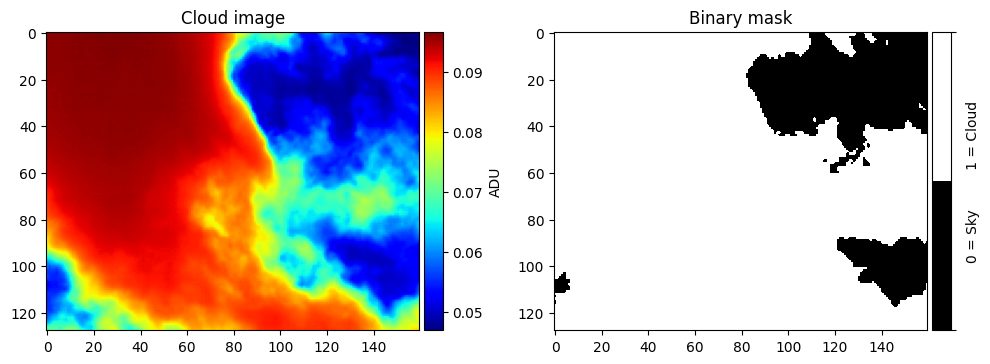

In [13]:
random_index = random.randint(0, len(l_fits) - 1)
util.plot_image(data=l_fits[random_index])
random_index = random.randint(0, len(l_fits) - 1)
util.plot_image(data=l_fits[random_index])
random_index = random.randint(0, len(l_fits) - 1)
util.plot_image(data=l_fits[random_index])
random_index = random.randint(0, len(l_fits) - 1)
util.plot_image(data=l_fits[random_index])

## Data set gen and batching

the data set generator is used to train on batches of images\
Each set of batch is augmented by a parameter `aug_batch_size`


In [ ]:
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=8,aug_batch_size=2, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.aug_batch_size = aug_batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]
        # Create a list of tuples using zip
        batch_list = list(zip(batch_x, batch_y))

        if self.aug_batch_size != 0:
            l_fits_aug = [aug.random_augment(img_mask=random.choice(batch_list)) for _ in range(self.aug_batch_size)]
            fits_images_aug = np.array(l_fits_aug)

            batch_x =  np.concatenate((batch_x, fits_images_aug[:,0]), axis=0)
            batch_y =  np.concatenate((batch_y, fits_images_aug[:,1]), axis=0)

        return batch_x, batch_y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

Split the data set into training and validation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(l_fits[:,0], l_fits[:,1], test_size=0.2, random_state=42)

Load the dataset generator\
We choose not to augment the validation set because it does not make sense

In [19]:
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=16,aug_batch_size=8, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=8,aug_batch_size=0, shuffle=True)

## Training

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

history = model.fit(ds_train_gen,validation_data=ds_val_gen, epochs=100, callbacks=[lr_schedule, early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
73/73 [==============================] - 51s 530ms/step - loss: 0.3910 - accuracy: 0.8301 - val_loss: 0.4021 - val_accuracy: 0.8410 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
73/73 [==============================] - 32s 439ms/step - loss: 0.3878 - accuracy: 0.8280 - val_loss: 0.4103 - val_accuracy: 0.8410 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
73/73 [==============================] - 32s 440ms/step - loss: 0.3991 - accuracy: 0.8276 - val_loss: 0.4232 - val_accuracy: 0.8410 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
73/73 [==============================] - 32s 439ms/step - loss: 0.3824 - accuracy: 0.8334 - val_loss: 0.4071 - val_accuracy: 0.8410 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
73/73 [==============================] -

In [ ]:
# Plotting
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
model.save('full_model.h5')

## Inference (predition) and plot result

In [25]:
batch_size = 5  # Set the batch size that works for your memory capacity

# Calculate the number of batches
num_batches = len(X_test) // batch_size

# Initialize an empty list to store predictions
all_predictions = []

# Predict using batches
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size

    batch_X = X_test[start_index:end_index]
    batch_predictions = model.predict(batch_X)
    print(batch_predictions.shape)
    all_predictions.append(batch_predictions)

# If there are any remaining samples not covered by full batches
if len(X_test) % batch_size != 0:
    last_batch_X = X_test[num_batches * batch_size:]
    last_batch_predictions = model.predict(last_batch_X)

    all_predictions.append(last_batch_predictions)

# Combine predictions from all batches
predictions = np.vstack(all_predictions)  # Assuming numpy is imported
y_predictions = np.squeeze(predictions, axis=-1)

1/1 [==============================] - 2s 2s/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 23ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 22ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 20ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 24ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 20ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 22ms/step
(5, 128, 160, 1)
1/1 [==============================] - 0s 21ms/step
(5, 128, 160, 1)
1/1 [==============================]

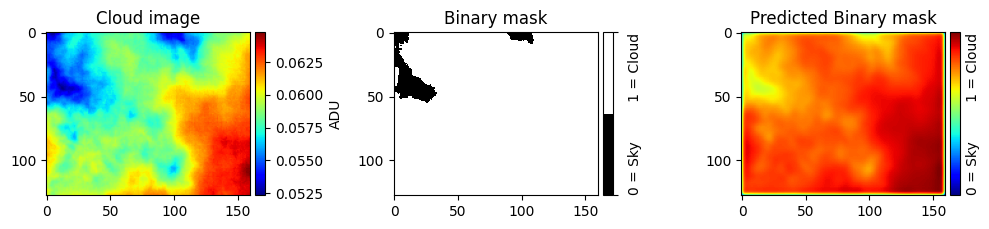

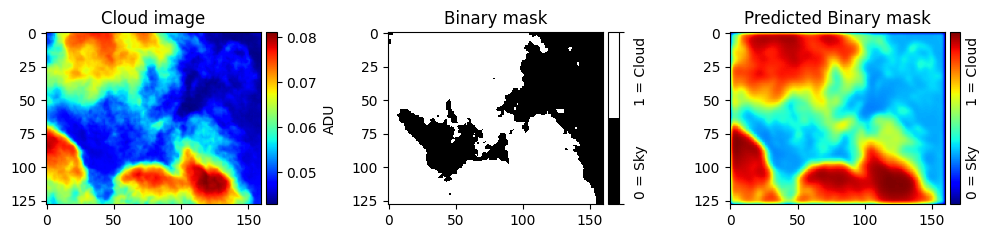

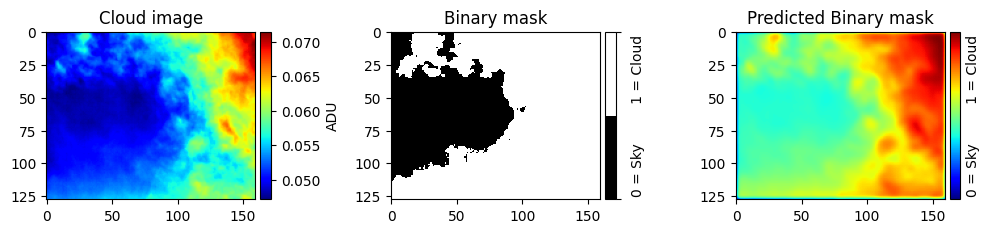

In [42]:
random_index = random.randint(0, len(X_test) - 1)
util.plot_image_pred(X_test[random_index], y_test[random_index], y_predictions[random_index],predmask_cmap='jet')
random_index = random.randint(0, len(X_test) - 1)
util.plot_image_pred(X_test[random_index], y_test[random_index], y_predictions[random_index],predmask_cmap='jet')
random_index = random.randint(0, len(X_test) - 1)
util.plot_image_pred(X_test[random_index], y_test[random_index], y_predictions[random_index],predmask_cmap='jet')